# Develops the Calculation Model for the Online Calculator

In [3]:
import sys
from importlib import reload
import inspect
import pandas as pd
import numpy as np
# import matplotlib pyplot commands
from matplotlib.pyplot import *
from IPython.display import Image, Markdown
 
# Show Plots in the Notebook
%matplotlib inline
 
# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

In [4]:
rcParams['figure.figsize']= (10, 6)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart

In [5]:
# Access the directory where some utility modules are located in the
# actual heat pump calculator.
sys.path.insert(0, '../../heat-pump-calc/heatpump/')

In [6]:
import library as lib
reload(lib)

<module 'library' from '../../heat-pump-calc/heatpump/library.py'>

In [97]:
class HomeEnergyModel(object):
    
    def __init__(self,
                 city_id,
                 utility_id,
                 hp_model_id,
                 exist_heat_fuel_id,
                 exist_heat_effic=0.8,
                 heat_effic_true_up=1.0,     # used to true-up estimated fuel use to actual
                 exist_is_point_source=False,
                 exist_annual_fuel_use=None,
                 includes_dhw=False,
                 dhw_occupant_count=3,
                 low_temp_cutoff=5.0,
                 garage_stall_count=0,
                 garage_heated_by_hp=False,
                 bldg_floor_area=2000,
                 insul_level=2,    # 1 - 2x4, 2 - 2x6, 3 - better than 2x6 Walls
                 ua_true_up=1.0,   # used to true up calculaion to actual fuel use
                 pct_exposed_to_hp=0.46,
                 doors_open_to_adjacent=False,
                 low_temp_acceptance=2,     # 1 - no temp drop in back rooms, 2 - 4 deg F cooler, 10 deg F cooler
                 hp_only=False,          # when using heat pump, it's the only heat source for home
                 no_heat_pump_use=False,  # If True, models existing heating system alone.
                ):
        # Store all of these input parameters as object attributes
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        for arg in args[1:]:
            setattr(self, arg, values[arg])
    
    # --------------------------------------------------------------
    # Some of the class properties are ID values that need to be 
    # used to bring in the associated object.  Do that with properties
    # so that if a new ID is set, an object look-up occurs.  Also make
    # properties for values that if changed affect the precalculation
    # of the self.df_hourly DataFrame.
    
    @property
    def city_id(self):
        return self._city_id
    
    @city_id.setter
    def city_id(self, value):
        self._city_id = value
        self._city = lib.city_from_id(value)
        self.make_hourly_df()
        
    @property
    def city(self):
        return self._city

    @property
    def utility_id(self):
        return self._utility_id
    
    @utility_id.setter
    def utility_id(self, value):
        self._utility_id = value
        self._utility = lib.util_from_id(value)
        
    @property
    def utility(self):
        return self._utility
    
    @property
    def hp_model_id(self):
        return self._hp_model_id
    
    @hp_model_id.setter
    def hp_model_id(self, value):
        self._hp_model_id = value
        self._hp_model = lib.heat_pump_from_id(value)
        self.make_hourly_df()
        
    @property
    def hp_model(self):
        return self._hp_model
    
    @property
    def exist_heat_fuel_id(self):
        return self._exist_heat_fuel_id
    
    @exist_heat_fuel_id.setter
    def exist_heat_fuel_id(self, value):
        self._exist_heat_fuel_id = value
        self._exist_heat_fuel = lib.fuel_from_id(value)
        
    @property
    def exist_heat_fuel(self):
        return self._exist_heat_fuel
    
    @property
    def low_temp_cutoff(self):
        return self._low_temp_cutoff

    @low_temp_cutoff.setter
    def low_temp_cutoff(self, value):
        self._low_temp_cutoff = value
        self.make_hourly_df()
    
    # ------------------ UTILITY FUNCTIONS ----------------------
    
    def missing_attr(self, *args):
        """Returns true if any of the arguments are not attributes on this
        object.
        """
        for arg in args:
            if not hasattr(self, arg):
                return True
        return False

    # -------------------- PRECALCULATE HOURLY DATAFRAME ----------------------------
    # This is done because the main calculate() method needs to be run
    # multiple times, but often with the same hourly input values.  So, it
    # saves calculation to precalculate this once and reuse.
    
    # Piecewise linear COP vs. outdoor temperature.
    COP_vs_TEMP = (
        (-20.0, 1.1),
        (0.0, 2.0),
        (10.0, 2.2),
        (15.0, 2.3),
        (20.0, 2.5),
        (25.0, 2.7),
        (30.0, 2.8),
        (40.0, 3.0),
        (50.0, 3.2)
    )

    # convert to separate lists of temperatures and COPs
    TEMPS_FIT, COPS_FIT = tuple(zip(*COP_vs_TEMP))

    # The HSPF value that this curve is associated with
    BASE_HSPF = 13.3
    
    def make_hourly_df(self):
        """Makes a DataFrame with a row for each hour, and the columns contain
        the hourly information necessary in the hourly heat pump model.  Stores
        the DataFrame as the 'df_hourly' attribute of this object.
        The inputs needed for this are all object attributes: city, hp_model, and
        low_temp_cutoff.
        """
        if self.missing_attr('city', 'hp_model', 'low_temp_cutoff'):
            self.df_hourly = None
            return
        print('make hourly')
        
        df_tmy = lib.tmy_from_id(self.city.TMYid)
        self.df_hourly = df_tmy[['db_temp']].copy()
        self.df_hourly['day_of_year'] = self.df_hourly.index.dayofyear
        self.df_hourly['month'] =  self.df_hourly.index.month

        # Determine days that the heat pump is running.  Look at the minimum
        # temperature for the day, and ensure that it is above the low 
        # temperature cutoff.
        hp_is_running = lambda x: (x.min() > self.low_temp_cutoff)
        self.df_hourly['running'] = self.df_hourly.groupby('day_of_year')['db_temp'].transform(hp_is_running)

        # Determine a heat pump COP for each hour
        cop_interp = np.interp(self.df_hourly.db_temp, 
                               HomeEnergyModel.TEMPS_FIT, 
                               HomeEnergyModel.COPS_FIT)
        self.df_hourly['cop'] = cop_interp * self.hp_model.hspf / HomeEnergyModel.BASE_HSPF
        
    def calculate(self):
        """Main calculation routine that models the home and determines
        loads and fuel use by hour.  Also calculates summary results.
        """
        # Set up some shortcut variables to shorten calculation code
        s = self
        dfh = s.df_hourly
        
        # adjustment to UA for insulation level 
        ua_insul_adj = (1.25, 1.0, 0.75)[s.insul_level - 1]
        # The UA values below are Btu/hr/deg-F
        ua_home = 0.18 * ua_insul_adj * s.bldg_floor_area * s.ua_true_up
        garage_area = (0, 14*22, 22*22, 36*25, 48*28)[s.garage_stall_count]
        ua_garage = 0.2 * ua_insul_adj * garage_area * s.ua_true_up

        # Balance Points of main home and garage
        balance_point_home = (65.0, 60.0, 53.0)[s.insul_level - 1]
        balance_point_garage = (52.0, 50.0, 47.0)[s.insul_level - 1]
        
        # BTU loads in the hour for the heat pump and for the secondary system.
        hp_load = []
        secondary_load = []

        for _, h in dfh.iterrows():
            # calculate total heat load for the hour.
            # Really need to recognize that delta-T to outdoors is lower in the adjacent and remote spaces
            # if there heat pump is the only source of heat.
            home_load = max(0.0, balance_point_home - h.db_temp) * ua_home 
            garage_load = max(0.0, balance_point_garage - h.db_temp) * ua_garage
            total_load = home_load + garage_load
            if not h.running or s.no_heat_pump_use:
                hp_load.append(0.0)
                secondary_load.append(total_load)
            else:
                max_hp_output = s.hp_model.in_pwr_5F_max * h.cop * 3412.
                if s.hp_only:
                    hp_ld = min(home_load + garage_load * s.garage_heated_by_hp, max_hp_output)
                    hp_load.append(hp_ld)
                    secondary_load.append(total_load - hp_load)
                else:
                    # Nowhere near correct yet.  Just get a calc framework working.
                    hp_ld = min(home_load * s.pct_exposed_to_hp + garage_load * s.garage_heated_by_hp, max_hp_output)
                    hp_load.append(hp_ld)
                    secondary_load.append(total_load - hp_ld)

        dfh['hp_load'] = hp_load
        dfh['secondary_load'] =  secondary_load

        # using array operations, calculate kWh use by the heat pump and 
        # the Btu use of secondary system.
        dfh['hp_kwh'] = dfh.hp_load / dfh.cop / 3412.
        dfh['secondary_fuel'] = dfh.secondary_load / (s.exist_heat_effic * s.heat_effic_true_up)
        year_tot = dfh[['hp_load', 'secondary_load', 'hp_kwh', 'secondary_fuel']].sum()
        print(f'{year_tot.secondary_fuel / 135000.:,.1f} gallons, {year_tot.hp_kwh:,.0f} kWh')
        if year_tot.hp_kwh:
            print(f'Seasonal COP: {year_tot.hp_load / year_tot.hp_kwh / 3412.:.2f}')
        
    def describe(self):
        """Returns a string with all the object attributes shown.  Text is truncated
        at 1,000 characters for attributes with long representations.
        """
        s = ''
        for attr in self.__dict__:
            val = repr(self.__dict__[attr])[:1000]
            if len(val)>50:
                s+=f'\n{attr}:\n{val}\n\n'
            else:
                s += f'{attr}: {val}\n'
        return s

In [98]:
m = HomeEnergyModel(257, 53, 575, 4)
m.calculate()

make hourly
361.9 gallons, 2,841 kWh
Seasonal COP: 2.89


In [89]:
m = HomeEnergyModel(257, 53, 575, 4)
m.garage_stall_count = 1
m.bldg_floor_area = 2100
m.insul_level = 1
m.garage_heated_by_hp = False
m.no_heat_pump_use = True
m.calculate()
m.no_heat_pump_use = False
m.calculate()

1,092.8 gallons, 0 kWh
668.4 gallons, 4,588 kWh
Seasonal COP: 2.93


In [63]:
print(m.describe())

_city_id: 257

_city:
Name                                                             Homer
Latitude                                                       59.6523
Longitude                                                      -151.53
ERHRegionID                                                          2
WAPRegionID                                                          2
FuelRefer                                                        False
FuelCityID                                                         NaN
Oil1Price                                                         2.72
Oil2Price                                                          NaN
PropanePrice                                                       4.1
BirchPrice                                                         NaN
SprucePrice                                                        NaN
CoalPrice                                                          NaN
SteamPrice                                             

In [64]:
m.df_hourly.describe()

,db_temp,day_of_year,month,cop,hp_load,secondary_load,hp_kwh,secondary_fuel
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,38.797836,183.000000,6.526027,3.076907,3675.774291,5147.680525,0.373264,6434.600656
std,14.336010,105.372043,3.448048,0.319682,2652.286896,4495.318786,0.308068,5619.148483
min,-5.080000,1.000000,1.000000,1.864632,0.000000,0.000000,0.000000,0.000000
25%,28.040000,92.000000,4.000000,2.906105,1394.517600,2041.200000,0.121336,2551.500000
50%,41.000000,183.000000,7.000000,3.178947,3340.350720,4177.656000,0.305777,5222.070000
75%,50.000000,274.000000,10.000000,3.368421,5597.081280,7254.152640,0.552934,9067.690800
max,75.020000,365.000000,12.000000,3.368421,10620.126720,27993.168000,1.393737,34991.460000


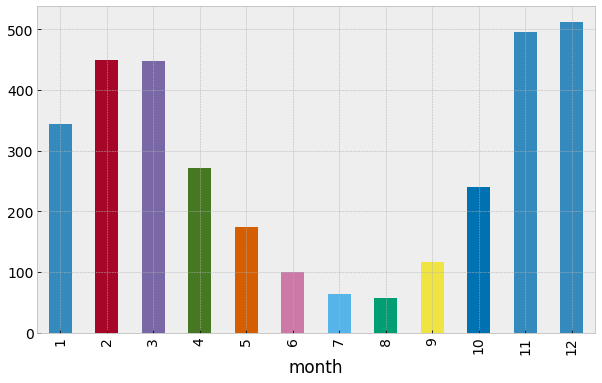

In [66]:
df_mo = m.df_hourly.groupby('month')[['hp_kwh', 'secondary_fuel']].sum()
df_mo.hp_kwh.plot(kind='bar')

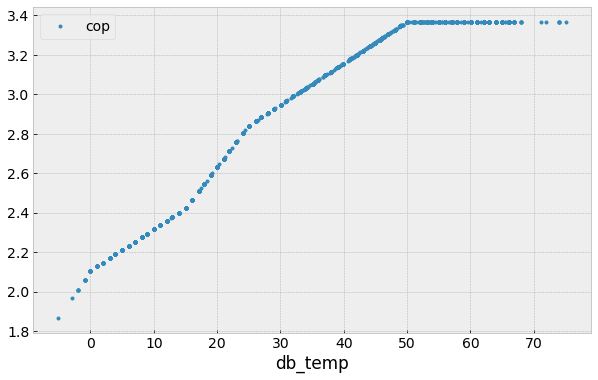

In [67]:
# Check whether COP is getting modeled correctly
m.df_hourly.plot(x='db_temp', y='cop', marker='.', linewidth=0)